<a href="https://colab.research.google.com/github/anshudaur/DeepLearning/blob/master/CVDL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np

# data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                          fname='flower_photos', untar=True)
# # print(data_dir)
# data_dir = pathlib.Path(data_dir)
# print(data_dir)

In [86]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/CVDL_Project/dataset/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [87]:
data_dir= pathlib.Path('gdrive/My Drive/CVDL_Project/dataset/train')
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

4918

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
def one_hot(i):
    a = np.zeros(102, 'uint8')
    a[i] = 1
    return a

In [90]:
import numpy as np
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)


['98' '99' '93' '97' '96' '94' '90' '95' '92' '91' '9' '89' '85' '82' '83'
 '84' '88' '86' '87' '81' '8' '80' '79' '78' '71' '72' '75' '74' '76' '73'
 '70' '77' '69' '7' '67' '68' '62' '61' '64' '63' '65' '60' '66' '6' '59'
 '58' '57' '56' '51' '49' '53' '54' '55' '52' '5' '50' '47' '48' '45' '40'
 '44' '41' '4' '43' '42' '46' '39' '38' '37' '36' '34' '31' '3' '35' '29'
 '32' '30' '33' '28' '27' '26' '25' '22' '18' '23' '21' '20' '24' '2' '19'
 '16' '17' '14' '15' '12' '11' '100' '102' '101' '1' '13' '10']


In [91]:
 train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES))

Found 4918 images belonging to 102 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
 image_batch, label_batch = next(train_data_gen)
 #show_batch(image_batch, label_batch)

In [94]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
print(list_ds)

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts[-2], parts.shape, parts[-2].shape)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  print(type(label),label.shape)
  #labelVector = tf.one_hot(label, depth=102).numpy()
  #print(labelVector.shape)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [98]:
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(type(labeled_ds))

Tensor("strided_slice:0", shape=(), dtype=string) (None,) ()
<class 'tensorflow.python.framework.ops.Tensor'> (102,)
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [99]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=6000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
# image_batch, label_batch = next(iter(labeled_ds))
# data = tf.data.Dataset.from_tensor_slices(
#     (image_batch.reshape(image_batch.shape[0],224,224,3).astype(np.float32) / 255, label_batch.astype(np.int32)))
# data = data.shuffle(buffer_size=60000).batch(128).repeat()

train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

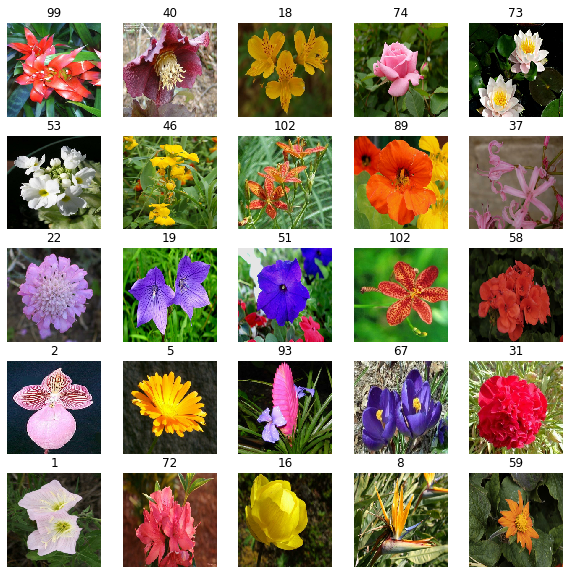

In [102]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [114]:
from tensorflow.keras import layers, models

#layer_list1 = [layers.Conv2D(128, (3, 3), activation='tanh', input_shape=(224, 224, 3)),
#              layers.Conv2D(128, (3, 3), activation='tanh'),
#              layers.Conv2D(256, (3, 3), activation='tanh'),layers.Conv2D(256, (3, 3), activation='tanh'),
#              layers.Flatten(),layers.Dense(102)]

#removed ,strides=(4,4) from first conv layer of layer_list2
layer_list2 = [layers.Conv2D(96, (11, 11),activation='tanh', input_shape=(224, 224, 3),padding = 'same'),
              layers.MaxPool2D(pool_size=(2,2)),
              layers.Conv2D(256, (5, 5), activation='tanh',padding = 'same'),
              layers.MaxPool2D(pool_size=(2,2)),
              layers.Conv2D(384, (3, 3), activation='tanh',padding = 'same'),
              layers.Conv2D(384, (3, 3), activation='tanh',padding = 'same'),
              layers.Conv2D(256, (3, 3), activation='tanh',padding = 'same'),
              layers.Flatten(),layers.Dense(256, activation ='relu'),layers.Dense(256, activation ='relu'),
              layers.Dense(102, activation ='softmax')]
model = tf.keras.Sequential(layer_list2)

opt = tf.keras.optimizers.Adam()
# from_logits = True!! #neverforget
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


ResourceExhaustedError: ignored

In [110]:
#model.compile(optimizer=opt, loss=loss_fn, metrics=[train_acc_metric])

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for image_batch, label_batch in enumerate(labeled_ds):
    #print(img_batch.shape)
    
    with tf.GradientTape() as tape:
        logits = model(image_batch)
        # loss format is generally: first argument targets, second argument outputs
        xent = loss_fn(lbl_batch, logits)

    # if you didn't build the model, it is important that you get the variables
    # AFTER the model has been called the first time
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        # this is different from before. there, we only evaluated accuracy
        # for one batch. Now, we always average over 100 batches
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        print('Seen so far: %s samples' % ((step + 1) * 64))
        train_acc_metric.reset_states()
    

ValueError: ignored

In [0]:
model.fit(image_batch, steps_per_epoch=10, epochs=2)
